In [2]:
! pip install mrjob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 21.7 MB/s eta 0:00:00


In [13]:
import json
import re
import string
import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm

# Download required NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Mapping Data: 701528it [00:09, 71613.42it/s] 



Top 20 most common words:
[('ANOMALY: Missing/short description', 701528)]

Total anomalies detected: 701528


In [17]:
file_path = "All_Beauty.jsonl"

with open(file_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(json.loads(line))  # Print first few records
        if i == 5:  # Limit to 5 samples
            break

{'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}
{'rating': 4.0, 'title': 'Works great but smells a little weird.', 'text': 'This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)', 'images': [], 'asin': 'B081TJ8YS3', 'parent_asin': 'B081TJ8YS3', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1

In [20]:
import json
from collections import Counter
from mrjob.job import MRJob

class ReviewWordCount(MRJob):
    def mapper(self, _, line):
        try:
            data = json.loads(line)  # Parse JSON line
            review_text = data.get("text", "").strip()

            if not review_text or len(review_text) < 5:
                yield ("ANOMALY: Missing/Short Review", 1)
            else:
                words = review_text.lower().split()
                for word in words:
                    yield (word, 1)
        except json.JSONDecodeError:
            yield ("ANOMALY: Invalid JSON", 1)

    def reducer(self, key, values):
        yield (key, sum(values))

# Run the MRJob inside the notebook
word_counts = Counter()
anomalies = Counter()

mr_job = ReviewWordCount(args=[])
with open("All_Beauty.jsonl", "r") as f:
    for line in f:
        for key, count in mr_job.mapper(None, line):
            if "ANOMALY" in key:
                anomalies[key] += count
            else:
                word_counts[key] += count

# Display Top 20 most common words
print("\nTop 20 Most Common Words:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

# Display Anomalies
print("\nDetected Anomalies:")
for anomaly, count in anomalies.items():
    print(f"{anomaly}: {count}")

# Display Total Word Count
print(f"\nTotal Unique Words: {len(word_counts)}")
print(f"Total Words Processed: {sum(word_counts.values())}")
print(f"Total Anomalies Detected: {sum(anomalies.values())}")



Top 20 Most Common Words:
the: 911302
i: 832268
and: 689280
it: 572492
a: 529557
to: 523432
my: 376638
this: 365748
is: 328617
for: 313854
of: 265967
but: 204610
in: 202609
not: 198599
was: 178231
on: 177977
with: 169787
have: 166232
that: 164070
so: 159374

Detected Anomalies:
ANOMALY: Missing/Short Review: 7459

Total Unique Words: 325265
Total Words Processed: 22968795
Total Anomalies Detected: 7459


In [21]:
# Install PySpark (if running in Google Colab, uncomment the next line)
# !pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, split, explode, count, desc, avg

# Initialize Spark Session
spark = SparkSession.builder.appName("BeautyReviewsEDA").getOrCreate()

# Load JSONL file into a Spark DataFrame
df = spark.read.json("All_Beauty.jsonl")

# Display schema and a few rows for inspection
df.printSchema()
df.show(5)

# Clean the data: Remove null reviews and short reviews (less than 5 characters)
df_filtered = df.filter((col("text").isNotNull()) & (col("text").rlike(".{5,}")))

# Select only relevant columns
df_filtered = df_filtered.select("asin", "rating", "text", "verified_purchase", "helpful_vote")

# WORD FREQUENCY ANALYSIS
df_words = df_filtered.withColumn("word", explode(split(lower(col("text")), "\s+")))
word_counts = df_words.groupBy("word").agg(count("*").alias("count"))
word_counts.orderBy(desc("count")).show(20)  # Show top 20 words

# AVERAGE RATING PER PRODUCT (ASIN)
df_avg_rating = df_filtered.groupBy("asin").agg(avg("rating").alias("avg_rating"))
df_avg_rating.orderBy(desc("avg_rating")).show(10)  # Show top 10 highest-rated products

# ANALYSIS OF VERIFIED VS. UNVERIFIED REVIEWS
df_verified = df_filtered.groupBy("verified_purchase").agg(count("*").alias("review_count"))
df_verified.show()

# MOST HELPFUL REVIEWS (SORTED BY HELPFUL VOTES)
df_helpful = df_filtered.orderBy(desc("helpful_vote"))
df_helpful.show(10)  # Show top 10 most helpful reviews

# EXPORT CLEANED DATA
df_filtered.write.json("cleaned_reviews.json")

# Stop the Spark session
spark.stop()


root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+-

Model Accuracy: 0.83


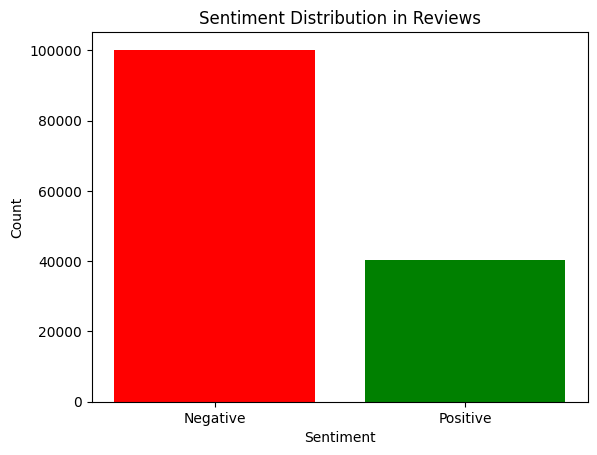

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Step 2: Load the dataset
df = spark.read.json("All_Beauty.jsonl")

# Step 3: Data Preprocessing
## Convert rating into binary sentiment (1 = positive, 0 = negative)
df = df.withColumn("sentiment", (col("rating") >= 4).cast("integer"))

## Select required columns and clean text
df = df.select("text", "sentiment").dropna()
df = df.withColumn("text", lower(col("text")))  # Convert text to lowercase
df = df.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z\s]", ""))  # Remove punctuation

# Convert sentiment column to numeric using StringIndexer
indexer = StringIndexer(inputCol="sentiment", outputCol="label")
df = indexer.fit(df).transform(df)

# Step 4: Feature Engineering
## Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

## Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

## Convert text to numerical features using TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=1000)
df = hashingTF.transform(df)

idf = IDF(inputCol="raw_features", outputCol="features")
df = idf.fit(df).transform(df)

# Step 5: Split Data into Training & Testing Sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Step 6: Train the Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
model = lr.fit(train_data)

# Step 7: Evaluate Model Performance
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy:.2f}")

# Step 8: Visualize Results
sentiment_counts = predictions.groupBy("label").count().collect()
labels = ["Negative", "Positive"]
counts = [row["count"] for row in sentiment_counts]

plt.bar(labels, counts, color=["red", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution in Reviews")
plt.show()

# Step 9: Stop the Spark Session
spark.stop()
